<a href="https://colab.research.google.com/github/fintech-projects/google-colab/blob/main/predict_live_image_using_custom_fingers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ORDER-MATE**

> A Machine Learning Model to predict user input picture of number selection using fingers count



Import google drive to google colab 

Import libraries 

In [ ]:
import numpy as np
import os,glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import io
from zipfile import ZipFile
from skimage.io import imread
from skimage.transform import resize 
import matplotlib.pyplot as plt
import random
import warnings
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
from sklearn import metrics
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import sgd
from tensorflow.keras.optimizers import SGD 
from keras.layers import LeakyReLU
from numpy import asarray
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

import time

print (tf.__version__)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


2.6.0


### Capture Live Photo

1630733307.8448868


<IPython.core.display.Javascript object>

1630733307.8448868.jpg


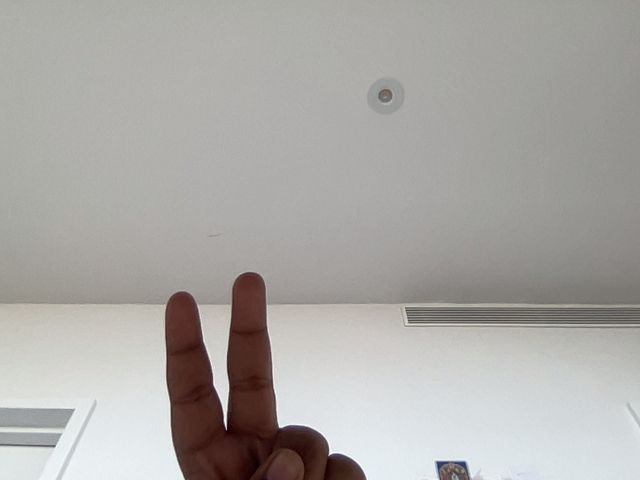

True

In [ ]:
## current_time is captured to be used as filename so that the inputs are unique 
current_time = time.time()

## function to take picture using device camera
def take_photo(filename='photo_live.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      
      ctx = canvas.getContext("2d");
      ctx.fillStyle = "rgb(0,0,0)";
      ctx.fillRect(40,60,20,20);
      ctx.drawImage(video, 0, 0);

      //canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
input_live_file = str(current_time)+'.jpg'
img_captured_live = take_photo(input_live_file)
print (img_captured_live)

img_captured_live_with_path = '/content/'+img_captured_live
img = cv2.imread(img_captured_live, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

## save the captured image 
cv2.imwrite('/content/'+input_live_file, img)

In [ ]:
print (img_captured_live)


1630733307.8448868.jpg


Convert the captured color image to black and white before passing to model as the model was trained with black and white images only

In [ ]:
## function to convert the captured color image to gray scale 
def convertToBlackNWhite(img_captured_live):
  # Load image
  im = cv2.imread(img_captured_live)
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  s=hsv[:,:,1]
  fileName = 'blackNwhite-'+img_captured_live
  cv2.imwrite('/content/'+fileName,s)
  fileName_with_path = '/content/'+fileName
  #cv2.imwrite('/content/'+fileName, img)
  return fileName_with_path

blackNWhiteImage = convertToBlackNWhite(img_captured_live)


In [ ]:
print (blackNWhiteImage)

/content/blackNwhite-1630733307.8448868.jpg


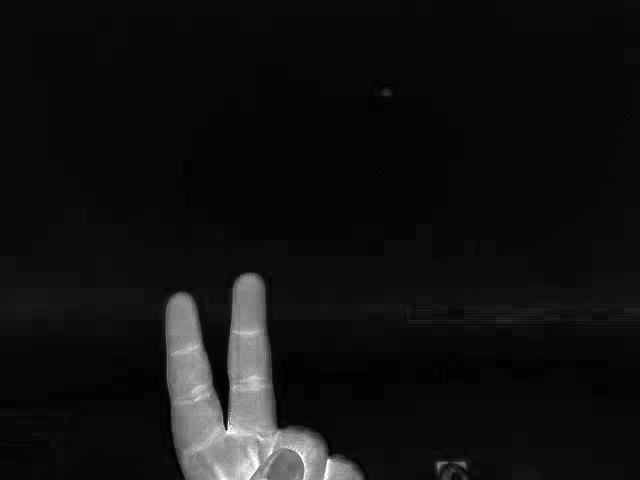

In [ ]:
img = cv2.imread(blackNWhiteImage, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# Importing the data and organizing it into folders

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d koryakinp/fingers
from zipfile import ZipFile
#file_name = "fingers.zip"
## instead of uploading the kaggle input everytime and extracting the dataset, that was saved in google drive for development purposes to reduce time consumption 
#file_name = "/content/FinTechProject-MachineLearning/MyDrive/fingers.zip"
file_name = "/content/fingers.zip"

In [ ]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import glob

Pngfiles_Train = []
Pngfiles_Test = []

os.chdir('/content/train')

for files in glob.glob("*.png"):
  Pngfiles_Train.append(files)

os.chdir('/content/test')

for files in glob.glob("*.png"):
  Pngfiles_Test.append(files)

In [ ]:
Classes = ['0L', '1L', '2L', '3L', '4L', '5L', '0R', '1R', '2R', '3R', '4R', '5R']

if not os.path.exists('/content/Train'):
  os.mkdir('/content/Train')

if not os.path.exists('/content/Test'):
  os.mkdir('/content/Test')

In [ ]:
for i in Classes:
  if not os.path.exists('/content/Train/'+i):
    os.mkdir('/content/Train/'+i)

for i in Classes:
  if not os.path.exists('/content/Test/'+i):
    os.mkdir('/content/Test/'+i)

In [ ]:
# Training set

import shutil

os.chdir('/content/train')

for i in Pngfiles_Train:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Train/{}'.format(last_two))

os.chdir('/content/test')
for i in Pngfiles_Test:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Test/{}'.format(last_two))

In [ ]:
Batch_size = 32
Image_size = (128,128)

test_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Test',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 3600 files belonging to 12 classes.


In [ ]:
class_names = test_set.class_names

# Loading the saved model

In [ ]:
model_saved = "/content/Fingers.h5"

Fingers_model = tf.keras.models.load_model(model_saved)

In [ ]:
Fingers_model.evaluate(test_set)

113/113 [==============================] - 4s 29ms/step - loss: 0.0460 - accuracy: 0.9831


[0.046049393713474274, 0.9830555319786072]

In [ ]:
Fingers_model.summary()

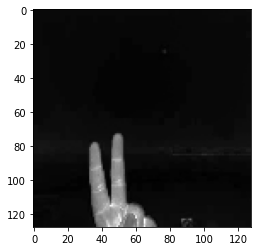

In [ ]:
## prepare the data input - user input by resizing before passing for prediction 

img = cv2.imread(blackNWhiteImage)
img = cv2.resize(img, (128,128))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image_np = np.array(img)

plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
image_np.shape

(128, 128, 3)

Output Or Prediction from User Input Image

In [ ]:
class_names[np.argmax(tf.nn.softmax(Fingers_model.predict(np.expand_dims(image_np,0))))]

'2R'

Conver to html for demo purposes if google colab is running slow 

In [ ]:
#pip install nbconvert

In [ ]:
#%%shell
#jupyter nbconvert '../predict_live_image.ipynb'